## Level 1 Requirement Flowdown

### L1-4 Regional Fluxes (Target Mode)

> For representative regions² (90 km × 90 km) Carbon-I shall obtain column averaged mixing ratios with a standard error ≤8 ppm CH4, ≤1.6 ppm CO2, and ≤10 ppb CO once averaged to a 1 km × 1 km grid for our reference scenario4 with a revisit capability ≤7 days. 


²: Representative regions are those that best exemplify major emission sectors—wetlands, agriculture, and waste—where emission uncertainty is high and process-based understanding remains limited.

---

Let's codify these numbers

In [1]:
# This Cell is used to set up the environment for the Carbon-I Open Source project.
include("setup-level1-packages.jl")
# This includes our Carbon-I and vSmartMOM packages (developed by our team)


  Activating project at `~/code/gitHub/CarbonI`
┌ Info: CUDA-enabled GPU(s) detected
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:57
┌ Info: CUDA.CuDevice(0): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:59
┌ Info: CUDA.CuDevice(1): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:59


req_vs_exp_table

---

### Define Requirements with corresponding units:

We utilize Julia's Unitful package here, which allows for automated unit conversion and propagation of units for any computation. 

In [2]:
# Taget Mode (L1-4) Aggregated Standard Error (ASE) requirements for a small 1km cloud-free box:
regional_mode_ch4_error = 10.0u"ppb"            # in ppb
regional_mode_co2_error =  2.5u"ppm"            # in ppm
regional_mode_co_error  = 10.0u"ppb"            # in ppb

# Regional Mode (L1-5)
regional_mode_grid_resolution = [1000u"m", 1000u"m"] # in m
regional_mode_revisit_days = 7 # in days, not used in the derivation here
regional_mode_region_size = [100e3u"km", 100e3u"m"]  # 100 km
# Account for median pixel size enhancements for GSD requirements at off-nadir angles

offNadir_factor = 2 # Account for GSD increase at 30/30 degree off nadir along and across track
regional_mode_gsd_req = [offNadir_factor*50.0u"m", 50.0u"m"]
regional_mode_gsd_cbe = [offNadir_factor*34.5u"m", 30.3u"m"]

# Reference Background VMRs
background_vmr_ch4 = 1900.0u"ppb"   # in ppb
background_vmr_co2 =  420.0u"ppm"   # in ppm
background_vmr_n2o =  330.0u"ppb";   # in ppb

Now we can compute the potential number of footprints in the regional grid, i.e.
$$
N_{max} = \frac{GSD_x \times GSD_y}{Grid_x \times Grid_y}
$$:

> In the target mode, we define the requirement for a 1km cloud free box (i.e. about a factor 2 smaller area than a regular OCO-2 footprint). Thus, the effective pixel number euqals the potential one.

In [3]:
# Maximum number of global ground pixels in the 12km box
# Req.
N_max_req = prod(regional_mode_grid_resolution)/prod(regional_mode_gsd_req);
# At CBE
N_max_cbe = prod(regional_mode_grid_resolution)/prod(regional_mode_gsd_cbe);



For regional mode, we select targets based on optimal visibility, defining a stricter criterion for cloud-free scenes. This demonstrates achievable performance under clear conditions outside the humid tropics, where surface albedo is typically higher. For tropical regions, achieving similar precision would require using a coarser inversion grid—an approach we can also illustrate.

In [4]:
# Number of cloud-free  ground pixels in the 1km box (here)
# Req.
f_cloud = 1.0
N_eff_req = N_max_req * f_cloud;
# At CBE
N_eff_cbe = N_max_cbe * f_cloud;

# Show the maximum number of pixels
show_pixels_table(N_max_req, N_eff_req, N_max_cbe, N_eff_cbe, grid_label="1km box, Target mode (no clouds)", render=:markdown)

| **Scenario** | **Max pixels in 1km box, Target mode (no clouds)** | **Cloud-free %** | **Effective pixels** |
|:-------------|---------------------------------------------------:|-----------------:|---------------------:|
| Required     | 200                                                | 100.0%           | 200                  |
| CBE          | 478                                                | 100.0%           | 478                  |


--- 
### Theoretical basis for uncertainty propagation

We can now derive the requirement for $\sigma_{s}^{rel}$, as:
$$
\sigma_s^{rel} < \underbrace{\sigma_{agg}^{rel}}_{Required} \times \sqrt{N_{eff}} \,
$$

and note that we derive the 1km average using the proxy method, i.e. the relative error is derived using

$$
\begin{align}
\sigma_s^{\mathrm{rel}}(R) & =  \sqrt{\sigma_{\mathrm{rel}}^2\bigl(\Omega_{{\tiny\mathrm{CH_4,CO_2}}}\bigr)
     +\sigma_{\mathrm{rel}}^2\bigl(\Omega_{\mathrm{N_2O}}\bigr)}\nonumber\\
& \approx  
\sigma_s^{\mathrm{rel}}(\Omega_{\mathrm{N_2O}})
\tag{D--8}
\end{align}
$$

For our derivation here, we actually use a constant conservative factor to account for teh contribution of the relative error of either CO2 or CH4 to the proxy error budget

In [25]:
sigma_rel_agg_req      =  min(regional_mode_ch4_error/background_vmr_ch4 ,  regional_mode_co2_error/background_vmr_co2)  # This should effectively be the same relative error for CO2 and CH4
sigma_rel_SingleSounding_req  =  sigma_rel_agg_req * sqrt(N_eff_req)  
sigma_rel_SingleSounding_cbe  =  sigma_rel_agg_req * sqrt(N_eff_cbe)
req_co_error = sqrt(N_eff_req) * regional_mode_co_error
@printf("Required relative error in σ_agg : %.3g\n", 100*sigma_rel_agg_req)
#@printf("Required Single Measurement Precision for CO in ppb for req. GSD : %.3g\n", ustrip(req_co_error))
@printf("Required Single Measurement Precision for N₂O in percent for req. GSD : %.3g\n", 100*sigma_rel_SingleSounding_req)
@printf("Required Single Measurement Precision for N₂O in percent for CBE specs: %.3g\n", 100*sigma_rel_SingleSounding_cbe)




Required relative error in σ_agg : 0.526
Required Single Measurement Precision for N₂O in percent for req. GSD : 7.44
Required Single Measurement Precision for N₂O in percent for CBE specs: 11.5


In [26]:
@show 100*sigma_rel_agg_req

100sigma_rel_agg_req = 0.5263157894736842


0.5263157894736842

Just to show that the CH4 or CO2 precisions hardly matter for the relative errors:
$$
\sigma_{\mathrm{rel}}(R)
\;=\;\sqrt{\;\sigma_{\mathrm{rel}}^2\!\bigl(\Omega_{\mathrm{CH_4,CO_2}}\bigr)
+\;\sigma_{\mathrm{rel}}^2\!\bigl(\Omega_{\mathrm{N_2O}}\bigr)\,},
$$

In [27]:
σ_n2o = 3.5 # Error in %
σ_ghg = 0.5 # Error in % (CO2 and CH4, even smaller than that)
σ_rel = sqrt(σ_n2o^2 + σ_ghg^2)
@printf("Error Enhancement factor if also considering GHG noise: %.3g\n", σ_rel / σ_n2o)
ampl = σ_rel / σ_n2o;

Error Enhancement factor if also considering GHG noise: 1.01


Now we have to show what instrument specs we require to get to that precision. 
--> We could bypass SNR and just use our nominal reference scene (with spectrally flat albedo) and compute sigma as function of total system efficiency (i.e. optical throughput and Qe)

In [8]:
# Load Reference scenario (Typical scene)
scenario = CarbonI.reference_scenario()

req_specs = CarbonI.build_instrument("Requirement") 
cbe_specs = CarbonI.build_instrument("CBE") 

# Create required Instrument model 
ins_req = InstrumentOperator.createGratingNoiseModel(req_specs.ET, req_specs.Pitch, 
		req_specs.FPA_quantum_efficiency, req_specs.bench_efficiency, 
		req_specs.Fnumber, 2*req_specs.SSI, 
		(req_specs.readout_noise), req_specs.dark_current); 

# Create required Instrument model
ins_cbe = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 
		cbe_specs.FPA_quantum_efficiency, cbe_specs.bench_efficiency, 
		cbe_specs.Fnumber, 2*cbe_specs.SSI, 
		(cbe_specs.readout_noise), cbe_specs.dark_current); 

# Load albedo for the scenes		
soil_req, x_req, solarIrr_req, σ_matrix_req, profile_req, h_req, Sₐ_req = setup_data(scenario, req_specs)
soil_cbe, x_cbe, solarIrr_cbe, σ_matrix_cbe, profile_cbe, h_cbe, Sₐ_cbe = setup_data(scenario, cbe_specs);

(ds["T"])[iLon, iLat, :, timeIndex] = Union{Missing, Float32}[187.60953, 195.1012, 201.35501, 208.64655, 216.49673, 222.47076, 227.39767, 230.89746, 235.26309, 242.40393, 250.36801, 259.4926, 268.20334, 272.86224, 273.1006, 270.50668, 266.17313, 261.9602, 257.33777, 253.24066, 249.31465, 244.15125, 240.6859, 238.05463, 235.39015, 231.98767, 228.57484, 226.37009, 223.45546, 222.34386, 220.49219, 217.9867, 216.47473, 214.98712, 213.25296, 210.32483, 207.75937, 206.41586, 207.52103, 209.51251, 210.57042, 216.20634, 224.16565, 232.26859, 240.40128, 247.10199, 252.58617, 255.18288, 257.9303, 263.41864, 267.52917, 272.1396, 276.66675, 280.92175, 284.42505, 286.95496, 289.00113, 290.2957, 290.15128, 289.2277, 289.0184, 290.03265, 291.2717, 292.5702, 293.89865, 295.23, 296.56677, 297.8983, 299.22983, 300.5767, 301.94052, 303.46246]


In [9]:
# Compute spectrally resolved albedo at model grid (spline)
refl_req   = scenario.surface_albedo(req_specs.modelling_wl);

In [10]:
error_req, F_req = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req, Sₐ_req, return_F=true) 
error_cbe, F_cbe = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_req, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe, Sₐ_cbe, return_F=true) 

(Dict{Any, Any}("ch4" => 10.169267298478452, "h2o" => 25789.69301820579, "co" => 42.66610353980517, "n2o" => 19.75235224462953, "hdo" => 174588.2237841886, "c2h6" => 25.612590001902237, "co2" => 2197.705247128854, "co213" => 15617.578884458344), [2.9347659998209354, 2.9244170677547787, 2.7861478511231725, 2.458574551410483, 2.3708779581014725, 2.101959738259233, 1.5845150034998492, 1.8872018549331286, 2.487426918603361, 2.544563990075057  …  1.5793954880093588, 1.356428405620226, 0.9376469195457674, 0.8197518012739107, 0.7713671562665957, 0.7435625617427714, 0.689547995241922, 0.32934537134544783, 0.2291102579894721, 0.540061696871597])

In [11]:
@show error_cbe["co"]
@show error_cbe["co2"]/1e3
@show error_cbe["ch4"]

error_cbe["co"] = 42.66610353980517
error_cbe["co2"] / 1000.0 = 2.197705247128854
error_cbe["ch4"] = 10.169267298478452


10.169267298478452

In [12]:
# Recompute for CBE but at 50m, i.e. 57ms
ins = InstrumentOperator.createGratingNoiseModel(57.0u"ms", cbe_specs.Pitch, cbe_specs.FPA_quantum_efficiency, cbe_specs.bench_efficiency, 
cbe_specs.Fnumber, 2*cbe_specs.SSI, (cbe_specs.readout_noise), cbe_specs.dark_current); 
error_cbe_50, F_cbe = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_req, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins, Sₐ_cbe, return_F=true) 
@show error_cbe_50["n2o"]u"ppb"/background_vmr_n2o

(error_cbe_50["n2o"] * u"ppb") / background_vmr_n2o = 0.05144272570700252


0.05144272570700252

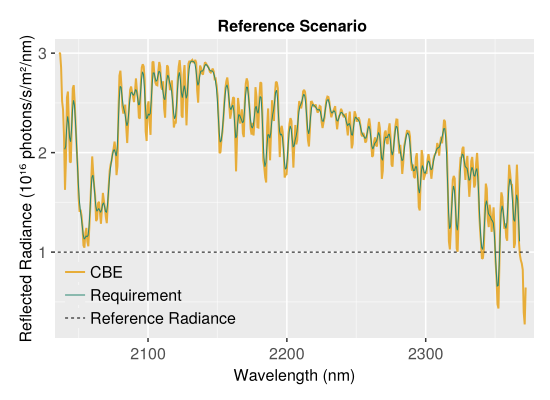

In [13]:
refRadiance = 1.0e16 # in photons/s/m²/nm
from_w_to_photons = 5.03e12
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Reflected Radiance (10¹⁶ photons/s/m²/nm)",  title="Reference Scenario ")
lines!(ax, cbe_specs.instrument_wl,F_cbe * from_w_to_photons .* cbe_specs.instrument_wl/1e16, color=CarbonI_colors[1], linewidth=2, label="CBE")
lines!(ax, req_specs.instrument_wl,F_req * from_w_to_photons .* req_specs.instrument_wl/1e16, color=CarbonI_colors[3], linewidth=1, label="Requirement")
lines!(ax, [2035,2375], [refRadiance/1e16,refRadiance/1e16], color=:black, linestyle=:dash, linewidth=1, label="Reference Radiance")
xlims!(ax, 2033, 2378)
axislegend(ax,position = :lb)
save("../../plots/final/Level1-4-BaselineScenario.pdf",f)
f

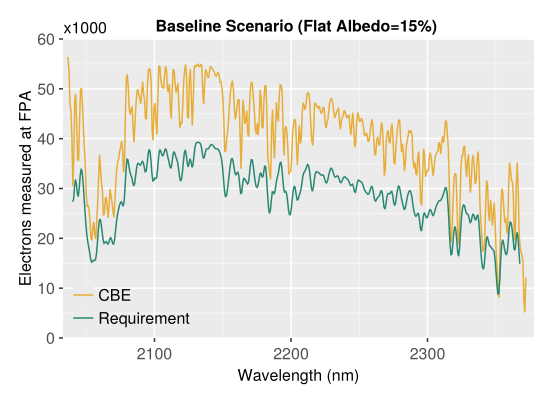

In [14]:
# Compute Electrons at FPA
e_cbe = InstrumentOperator.photons_at_fpa(ins_cbe, (cbe_specs.instrument_wl)u"nm", (F_cbe)u"mW/m^2/nm/sr");
e_req = InstrumentOperator.photons_at_fpa(ins_req, (req_specs.instrument_wl)u"nm", (F_req)u"mW/m^2/nm/sr");
from_w_to_photons = 5.03e12
refRadiance = 1.0e16 # in photons/s/m²/nm

f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Electrons measured at FPA",  title="Baseline Scenario (Flat Albedo=15%) ")
Label(f[1, 1, Top()], halign = :left, "x1000")
lines!(ax, cbe_specs.instrument_wl,e_cbe/1000, color=CarbonI_colors[1], linewidth=1.5, label="CBE")
lines!(ax, req_specs.instrument_wl,e_req/1000, color=CarbonI_colors[3], linewidth=1.5, label="Requirement")
#lines!(ax, [2035,2375], [refRadiance/ 1e16,refRadiance/ 1e16], color=:black, linestyle=:dash, linewidth=1, label="Reference Tropical Radiance")
xlims!(ax, 2033, 2378)
axislegend(ax,position = :lb)
ylims!(ax, 0, 60)
save("../../plots/final/Level1-4-BaselineScenario_FPA.pdf",f)
f

In [15]:
# Save Data for plotting
allData_fpa_cbe = [cbe_specs.instrument_wl e_cbe];
allData_fpa_req = [req_specs.instrument_wl e_req];
writedlm("../../data/L1s/Level1-4-BaselineScenario_FPA_CBE.csv", allData_fpa_cbe);
writedlm("../../data/L1s/Level1-4-BaselineScenario_FPA_Req.csv", allData_fpa_req);

### Probe phase space of instrument performance and impact on single measurement precision

Here, we need to consider the nominal scenario, which is more typical for Target observations. Signal independent noise will not be as crucial as over the dark tropics.

We iterate over readout noise and total system efficiency to derive the dependency of precision on instrument specs

---

### Uncertainty Budget for a Single Footprint

We linearize the radiative transfer around a reference state $x_0$ and write the measurement model:

$$
y \;=\; F(x_0) \;+\; \mathbf{K}\,(x - x_0) \;+\; \varepsilon. \tag{D–4}
$$

Here, $ \mathbf{K} \equiv \partial F/\partial x $ is the Jacobian (spectral sensitivities) and $ \varepsilon \sim \mathcal{N}(0,\mathbf{S}_\varepsilon) $ is detector noise (shot + readout), which is computed mechanistically using our Instrument Model.

The posterior covariance of the retrieved state $ \hat{x} $ in a Bayesian estimator with prior $ \mathbf{S}_a $ is:

$$
\mathrm{Cov}(\hat{x}) \;=\; \hat{\mathbf{S}} \;=\; \big(\mathbf{K}^\top \mathbf{S}_\varepsilon^{-1}\mathbf{K} \;+\; \mathbf{S}_a^{-1}\big)^{-1}. \tag{D–5}
$$

For total columns $ \Omega_{\text{gas}} = \mathbf{h}_{\text{gas}}^\top \hat{x} $, the single-measurement precision follows:

$$
\sigma_s(\Omega_{\text{gas}}) \;=\; \sqrt{\mathbf{h}_{\text{gas}}^\top \hat{\mathbf{S}}\,\mathbf{h}_{\text{gas}}}. \tag{D–6}
$$

These expressions link instrument design (via $ \mathbf{K} $, spectral sampling, and SNR in $ \mathbf{S}_\varepsilon $) to per-footprint column precision used throughout the L1 derivations.

> With this setup, we can iterate through key instrument metrics and evaluate the impact on the retrieval precision 

In [16]:
# Now vary total efficiency at two different readout noise levels:

TotalEfficiencies = 0.3:0.05:1.0
n2o_errors_100 = zeros(length(TotalEfficiencies))
n2o_errors_120 = zeros(length(TotalEfficiencies))
for (i,efficiency) in enumerate(TotalEfficiencies)
    # Create instrument Specs here:
    # (here we need to use 57ms integration time for req. as we count 50m pixels along track dimension)
    ins_req_100 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (100.0), req_specs.dark_current); 
    ins_req_120 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current); 
    
    # Create an error for 100 and 120e- for the respective efficiency
    error_varied_100 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_100, Sₐ_req) 
    error_varied_120 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_120, Sₐ_req) 
    
    # Store Data (no co-adding applied here)
    n2o_errors_100[i] = error_varied_100["n2o"]u"ppb"/background_vmr_n2o
    n2o_errors_120[i] = error_varied_120["n2o"]u"ppb"/background_vmr_n2o
end

In [17]:
# Create an interpolation function to get the required optical efficiency for a given readout noise and proxy error for N2O
# Annoying as it requires ascending order in the x-axis
efficiency_100 = LinearInterpolation(reverse(100(n2o_errors_100)), reverse(TotalEfficiencies), extrapolation_bc=Line());
efficiency_120 = LinearInterpolation(reverse(100(n2o_errors_120)), reverse(TotalEfficiencies), extrapolation_bc=Line());

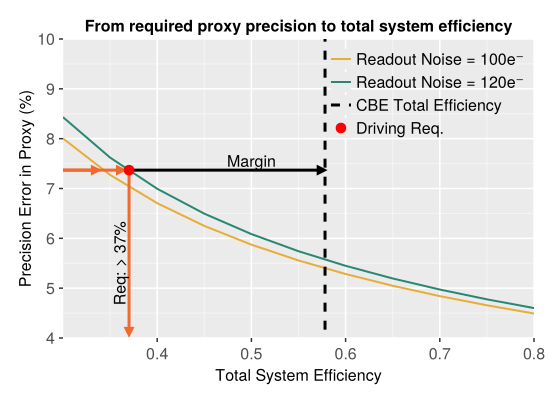

In [18]:
f = Figure(resolution=(550,400))
lowerLim = 4.0
ax = Axis(f[1,1], xlabel="Total System Efficiency", ylabel="Precision Error in Proxy (%)",  title="From required proxy precision to total system efficiency")
lines!(ax, TotalEfficiencies, n2o_errors_100*100, color=CarbonI_colors[1], linewidth=2, label="Readout Noise = 100e⁻")
lines!(ax, TotalEfficiencies, n2o_errors_120*100, color=CarbonI_colors[3], linewidth=2, label="Readout Noise = 120e⁻")

req_error        = 100*sigma_rel_SingleSounding_req /ampl
req_error_cbeGSD = 100*sigma_rel_SingleSounding_cbe /ampl
req_eff = efficiency_100(req_error)
req_eff_120 = efficiency_120(req_error)
eff_cbe = cbe_specs.bench_efficiency * cbe_specs.FPA_quantum_efficiency

arrows!(ax, [0.0,],[req_error,],[req_eff-0.01,],[0,],arrowsize = 15, linewidth=3,color = CarbonI_colors[5])
arrows!(ax, [0.0,],[req_error,],[req_eff_120-0.01,],[0,],arrowsize = 15, linewidth=3, color = CarbonI_colors[5])
arrows!(ax, [req_eff_120,],[req_error,],[eff_cbe-req_eff_120-0.005,],[0,],arrowsize = 15, linewidth=3, color = :black)
text!(ax, "Margin", position = (0.5, req_error),  align = (:center, :bottom), color = :black)
#arrows!(ax, [req_eff,],[req_error,],[0,],[-req_error+lowerLim + 0.05,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5])
##text!(ax, "Req: > $(round(Int, 100req_eff))%", position = (req_eff, 5.5),
 #   align = (:center, :bottom), color = :black, rotation=π/2)

arrows!(ax, [req_eff_120,],[req_error,],[0,],[-req_error+lowerLim+0.15,],arrowsize = 15, linewidth=3, color = CarbonI_colors[5])
text!(ax, "Req: > $(round(Int, 100req_eff_120))%", position = (req_eff_120, 5.5),
    align = (:center, :bottom), color = :black, rotation=π/2)
lines!(ax, [eff_cbe,eff_cbe], [2,10], color=:black, linestyle=:dash, linewidth=3, label="CBE Total Efficiency")
scatter!(ax, [req_eff_120], [req_error], color=:red, markersize=15, label="Driving Req.")
#arrows!(ax2, [req_percent_ch4,],[req_flux_ch4,],[-req_percent_ch4+1,],[0,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5])
#text!(ax2, "Req. >90%", position = (req_percent_ch4, 25),
#      align = (:center, :bottom), color = :black, rotation=π/2)

axislegend(ax,position = :rt)
xlims!(ax,0.3,0.8)
ylims!(ax,lowerLim,10)
save("../../plots/final/Level1-4-L1-5-reqs.pdf",f)
f

In [19]:
# Save lines to merge later with other requirements:
AllData = [TotalEfficiencies n2o_errors_100*100 n2o_errors_120*100 ];

writedlm("../../data/L1s/L1-4_lines.dat", AllData)
writedlm("../../data/L1s/L1-4_req_error.dat", req_error)

In [20]:
ins_req_forSNR = InstrumentOperator.createGratingNoiseModel(44.0u"ms", req_specs.Pitch, 1.0, req_eff_120, req_specs.Fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current);
ins_cbe_forSNR = InstrumentOperator.createGratingNoiseModel(44.0u"ms", cbe_specs.Pitch, 1.0, eff_cbe, cbe_specs.Fnumber, 2*cbe_specs.SSI, (100.0), cbe_specs.dark_current);
# Use reference Wavelength here (just for conversion)
ref_wl = 2250;

refRadiance = 1.0e16 # in photons/s/m²/nm
refRadiance_mw = refRadiance / from_w_to_photons / ref_wl
nesr_req_forSNR = InstrumentOperator.noise_equivalent_radiance(ins_req_forSNR, (ref_wl)u"nm", (refRadiance_mw)u"mW/m^2/nm/sr");
nesr_cbe_forSNR = InstrumentOperator.noise_equivalent_radiance(ins_cbe_forSNR, (ref_wl)u"nm", (refRadiance_mw)u"mW/m^2/nm/sr");

# @show refRadiance_mw/(nesr_req_forSNR[1]./1u"mW/m^2/nm/sr"), refRadiance_mw/(nesr_cbe_forSNR[1]./1u"mW/m^2/nm/sr")
@printf("Required SNR @1e16 photons/m2/sr/nm/s: %.4g\n",  refRadiance_mw/(nesr_req_forSNR[1]./1u"mW/m^2/nm/sr"))
@printf("CBE      SNR @1e16 photons/m2/sr/nm/s: %.4g",  refRadiance_mw/(nesr_cbe_forSNR[1]./1u"mW/m^2/nm/sr"))

Required SNR @1e16 photons/m2/sr/nm/s: 73.53
CBE      SNR @1e16 photons/m2/sr/nm/s: 110.3

In [21]:
# Show CBE expected precisions
md_expected_precisions(error_cbe, sqrt(1); sigdigits=4)

| Gas | Expected single-measurement precision | Unit |
|-----|--------------------------------------:|------|
| CH₄ | 10.17 | ppb |
| CO₂ | 2.198 | ppm |
| CO | 42.67 | ppb |


In [31]:
# Computing CBE for L1-5:
proxy_error = error_cbe["n2o"]u"ppb"/background_vmr_n2o
@show proxy_error
sigma_rel_cbe_agg = proxy_error / sqrt(N_eff_cbe)
@printf("CBE Standard Error for CH₄ : %.2g ppb\n", sigma_rel_cbe_agg*ustrip(background_vmr_ch4)) 
@printf("CBE Standard Error for CO₂ : %.2g ppm\n", sigma_rel_cbe_agg*ustrip(background_vmr_co2))
@printf("CBE Standard Error for CO  : %.2g ppb\n", error_cbe["co"]/ sqrt(N_eff_cbe))

# All older ones:
@printf("Required relative error in σ_agg : %.3g\n", 100*sigma_rel_agg_req)
@printf("Required Single Measurement Precision for CO in ppb for req. GSD : %.3g\n", ustrip(req_co_error))
@printf("Required Single Measurement Precision for N₂O in percent for req. GSD : %.3g\n", 100*sigma_rel_SingleSounding_req)
@printf("Required Single Measurement Precision for N₂O in percent for CBE specs: %.3g\n", 100*sigma_rel_SingleSounding_cbe)

# SNR @ ref Radiance:
@printf("Required SNR @1e16 photons/m2/sr/nm/s: %.4g\n",  refRadiance_mw/(nesr_req_forSNR[1]./1u"mW/m^2/nm/sr"))
@printf("CBE      SNR @1e16 photons/m2/sr/nm/s: %.4g\n",  refRadiance_mw/(nesr_cbe_forSNR[1]./1u"mW/m^2/nm/sr"))

# Total System Efficiency
@printf("Required Total System Efficiency: %.4g\n", req_eff_120)

# SNR @ ref Radiance:
@printf("Required SNR @1e16 photons/m2/sr/nm/s: %.4g\n",  refRadiance_mw/(nesr_req_forSNR[1]./1u"mW/m^2/nm/sr"))
@printf("CBE      SNR @1e16 photons/m2/sr/nm/s: %.4g\n",  refRadiance_mw/(nesr_cbe_forSNR[1]./1u"mW/m^2/nm/sr"))

# Pixels:
@printf("Number of cloud-free Pixel in Required GSD: %.3g\n", N_eff_req)
@printf("Number of cloud-free Pixel in CBE GSD: %.3g\n", N_eff_cbe)

proxy_error = 0.05985561286251373
CBE Standard Error for CH₄ : 5.2 ppb
CBE Standard Error for CO₂ : 1.1 ppm
CBE Standard Error for CO  : 2 ppb
Required relative error in σ_agg : 0.526
Required Single Measurement Precision for CO in ppb for req. GSD : 141
Required Single Measurement Precision for N₂O in percent for req. GSD : 7.44
Required Single Measurement Precision for N₂O in percent for CBE specs: 11.5
Required SNR @1e16 photons/m2/sr/nm/s: 73.53
CBE      SNR @1e16 photons/m2/sr/nm/s: 110.3
Required Total System Efficiency: 0.3701
Required SNR @1e16 photons/m2/sr/nm/s: 73.53
CBE      SNR @1e16 photons/m2/sr/nm/s: 110.3
Number of cloud-free Pixel in Required GSD: 200
Number of cloud-free Pixel in CBE GSD: 478


### The End